<a href="https://colab.research.google.com/github/tvml/ml2425/blob/master/codici/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Titanic disaster survivors

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew.  This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew.  Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

We analyze here what sorts of people were likely to survive, in order to predict, for each passenger, her chances of surviving the shipwreck and to evaluate the overall prediction performance of the algorithms applied.

In [2]:
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd 
import scipy.stats as stats
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve 
from sklearn.metrics import f1_score, precision_recall_fscore_support, roc_auc_score, make_scorer, auc
from sklearn.linear_model import LogisticRegression

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) 
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256)))

In [5]:
import urllib.request

filepath = "../dataset/"
url = "https://tvml.github.io/ml2425/dataset/"

def get_file(filename):
    IS_COLAB = ('google.colab' in str(get_ipython()))
    if IS_COLAB:
        urllib.request.urlretrieve (url+filename, filename)
        return filename
    else:
        return filepath+filename

### Data Handling
#### Let's read our data in using pandas:

In [6]:
df = pd.read_csv(get_file("titanic.csv"))

Show an overview of our data: 

In [7]:
df.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [68]:
df.shape

(891, 12)

In [7]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

These are the meanings of each feature:

*Survival*: Survival(0 = No; 1 = Yes)  
*Pclass*: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)  
*Name*: Name  
*Sex*: Sex (female, male)  
*Age*: Age  
*SibSp*: Number of Siblings/Spouses Aboard  
*Parch*: Number of Parents/Children Aboard  
*Ticket*: Ticket Number  
*Fare*: Passenger Fare  
*Cabin*: Cabin  
*Embarked*: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


To have a better vision of the data we are going to display our feature with a countplot of seaborn. Show the counts of observations in each categorical bin using bars. The categorical features of our dataset are these are integer and object. We are going to separate our features into two lists: “categ” for the categorical features and “conti” for the continuous features. The “age” and the “fare” are the only two features that we can consider as continuous. In order to plot the distribution of the features with seaborn we are going to use distplot. According to the charts, there are no weird values (superior at 100) for “age” but we can see that the feature “fare” have a large scale and the most of value are between 0 and 100.

In [70]:
df['TravelBuds'] = df["SibSp"]+df["Parch"]
df['Alone'] = np.where(df['TravelBuds']>0, 0, 1)
df.drop('TravelBuds', axis=1, inplace=True)

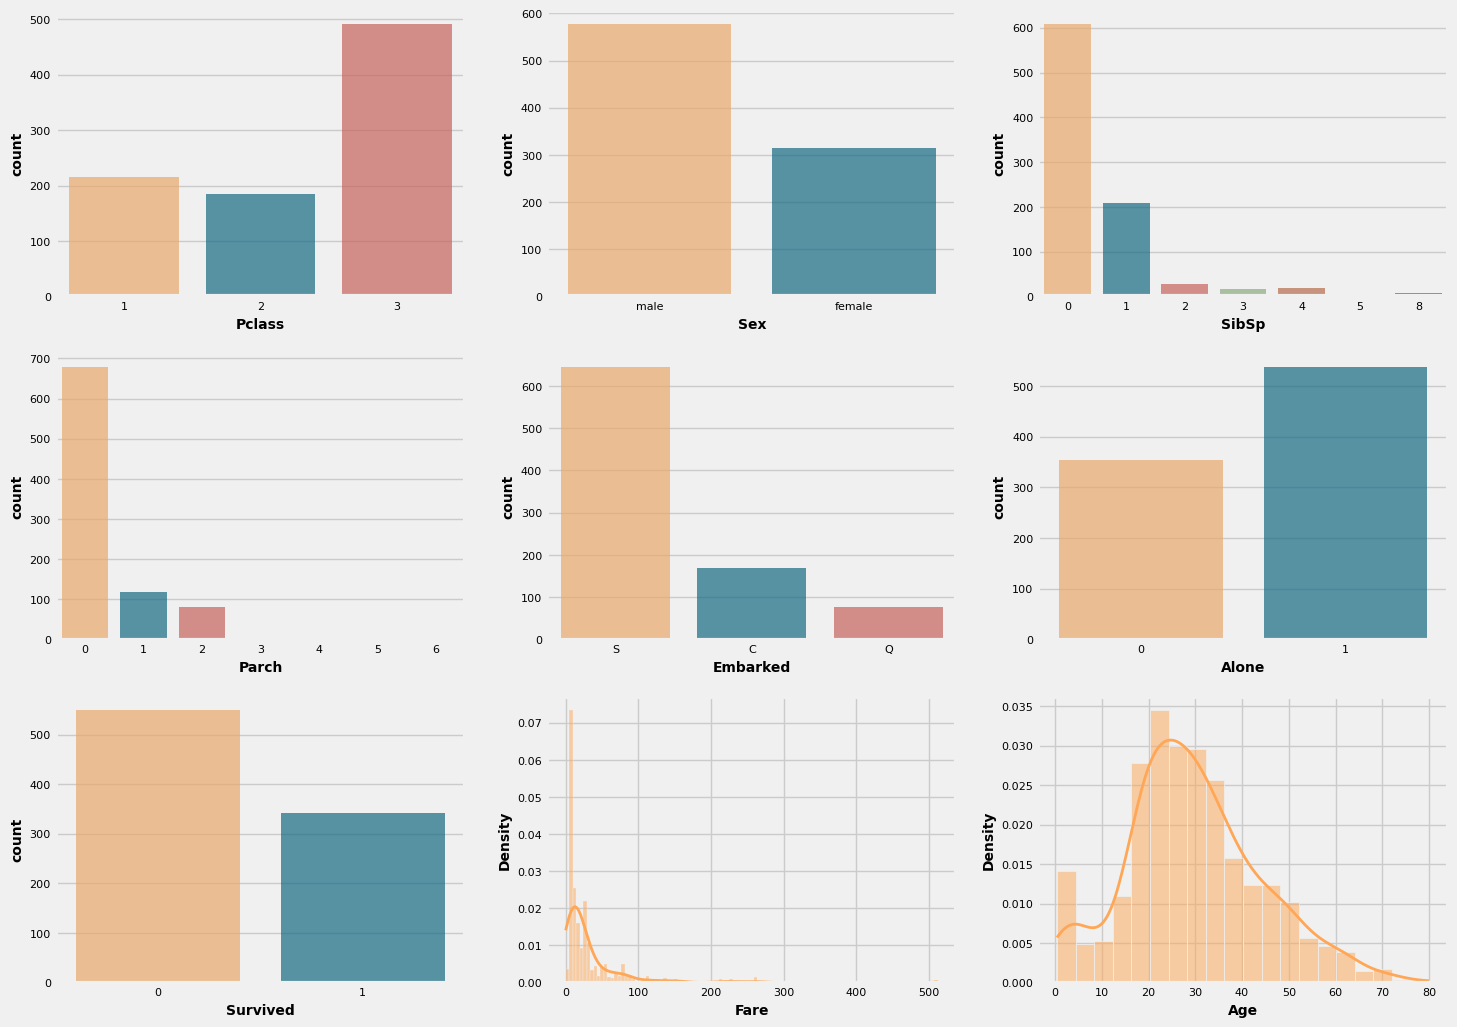

In [90]:
categ =  [ 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Alone', 'Survived']
conti = ['Fare', 'Age']

#Distribution
fig = plt.figure(figsize=(16, 12))
for i in range (0,len(categ)):
    fig.add_subplot(3,3,i+1)
    sns.countplot(x=categ[i], data=df, alpha=.7) 

for col in conti:
    fig.add_subplot(3,3,i + 2)
    sns.histplot(df[col].dropna(), kde=True, stat="density", line_kws={'lw':2,'color':colors[5]})
    i += 1
    
plt.show()

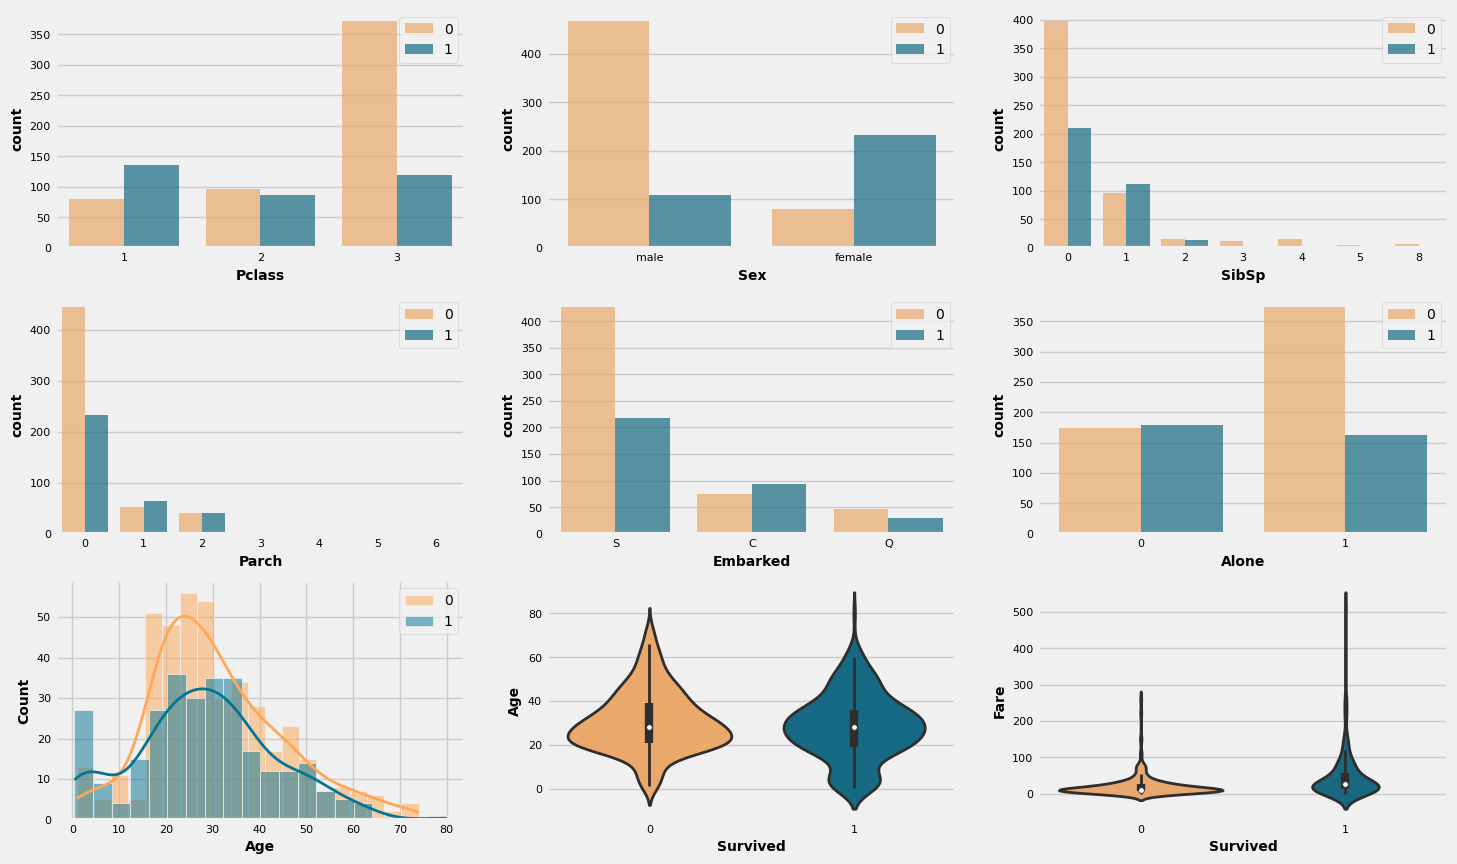

In [105]:
fig = plt.figure(figsize=(16, 10))
i = 1
for col in categ:
    if col != 'Survived':
        fig.add_subplot(3,3,i)
        g = sns.countplot(x=col, data=df,hue='Survived', alpha=.7)
        plt.legend(loc=1) 
        i += 1

# Box plot survived x age
fig.add_subplot(3,3,7)
#sns.swarmplot(x="Survived", y="Age", hue="Sex", alpha=.7, data=df)
sns.histplot(df[df.Survived==0]['Age'].dropna(), kde=True, bins = 20, line_kws={"lw": 2}, label='0')
sns.histplot(df[df.Survived==1]['Age'].dropna(), color=colors[1], kde=True, bins = 20, line_kws={"lw": 2}, label='1')
plt.legend()
fig.add_subplot(3,3,8)
sns.violinplot(x="Survived", y="Age", data=df, alpha=.7)

# fare and Survived
fig.add_subplot(3,3,9)
sns.violinplot(x="Survived", y="Fare", alpha=.7, data=df, saturation=.7)

plt.show()

### Let us evaluate some conditional probabilities of surviving

In [101]:
def cond_prob(feature):
    r = df[df[feature].notnull()][feature].unique()
    p = []
    for val in r:
        joint = df[(df[feature]==val) & (df['Survived']==1)].shape[0]
        pre = df[(df[feature]==val)].shape[0]
        post_1 = joint/pre
        p.append([val, post_1])
    return pd.DataFrame(p, columns=['value','prob'])

In [102]:
def cond_prob_2(feature1, feature2):
    r1 = df[(df[feature1].notnull())&(df[feature2].notnull())][feature1].unique()
    r2 = df[(df[feature1].notnull())&(df[feature2].notnull())][feature2].unique()
    p = []
    for val1 in r1:
        for val2 in r2:
            joint = df[(df[feature1]==val1) & (df[feature2]==val2) & (df['Survived']==1)].shape[0]
            pre = df[(df[feature1]==val1) & (df[feature2]==val2)].shape[0]
            post_1 = joint/pre
            p.append([val1, val2, post_1])
    return pd.DataFrame(p, columns=[feature1,feature2,'prob'])

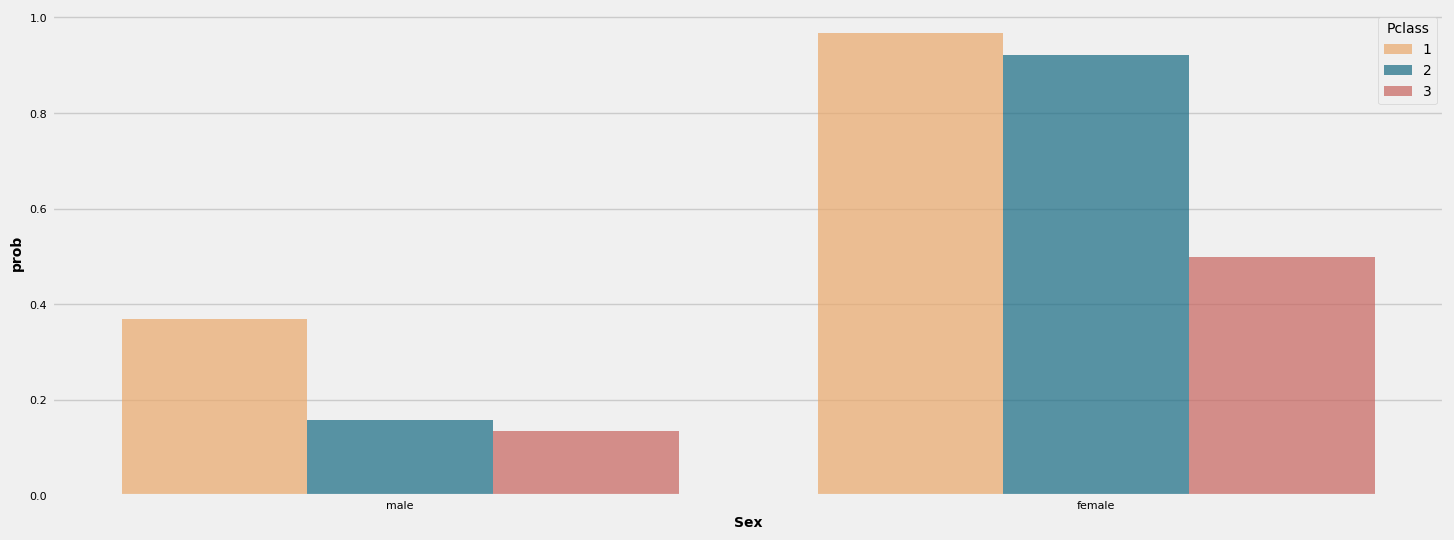

In [103]:
cp = cond_prob_2('Sex','Pclass')
fig = plt.figure(figsize=(16, 6))
sns.barplot(x=cp.columns[0], y=cp.columns[2], hue=cp.columns[1], data=cp, alpha=.7)
plt.show()

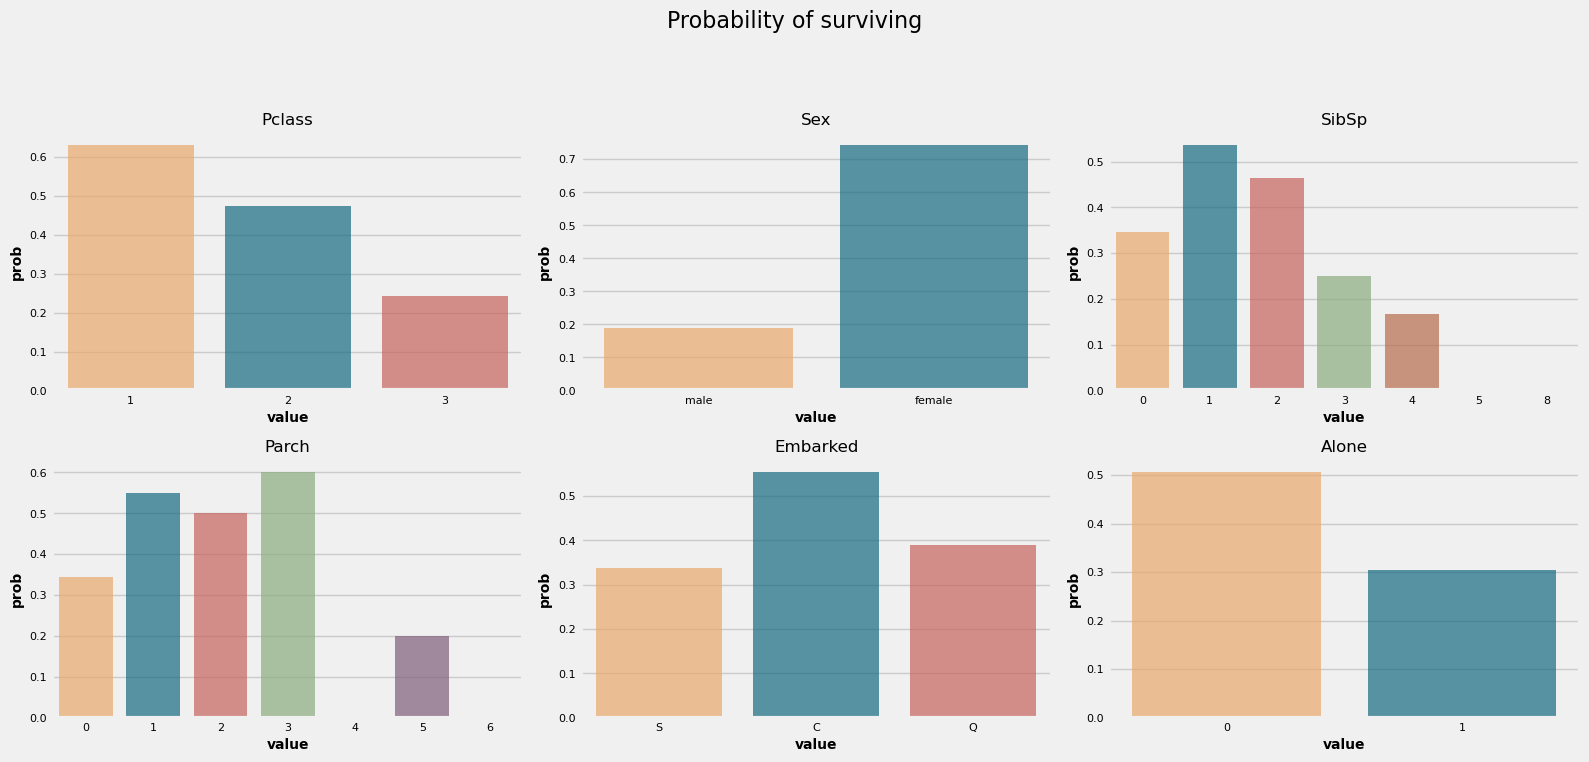

In [106]:
fig = plt.figure(figsize=(16, 10))
i = 1
for col in categ:
    if col!='Survived':
        fig.add_subplot(3,3,i)
        g = sns.barplot(x='value', y='prob', data=cond_prob(col), alpha=.7)
        plt.title(col, fontsize=12) 
        i += 1
plt.suptitle('Probability of surviving', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

In [107]:
frq00, edges = np.histogram(df[df.Survived==1].Age, bins=range(0,90,10))
frq01, edges = np.histogram(df.Age, bins=range(0,90,10))
frq0, edges = np.histogram(df[df.Sex=='male'].Age, bins=range(0,90,10))
frq1, edges = np.histogram(df[(df.Survived==1) & (df.Sex=='male')].Age, bins=range(0,90,10))
frq2, edges = np.histogram(df[df.Sex=='female'].Age, bins=range(0,90,10))
frq3, edges = np.histogram(df[(df.Survived==1) & (df.Sex=='female')].Age, bins=range(0,90,10))

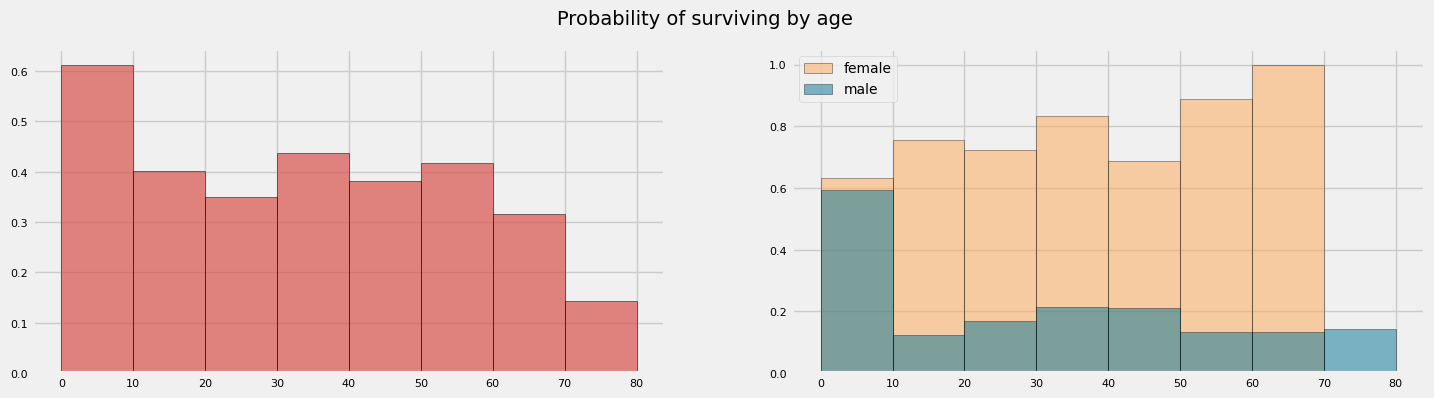

In [108]:
fig = plt.figure(figsize=(16,4))
fig.add_subplot(1,2,1)
plt.bar(edges[:-1], frq00/frq01, width=np.diff(edges), ec="k", align="edge", color=colors[2], alpha=.7)
fig.add_subplot(1,2,2)
plt.bar(edges[:-1], frq3/frq2, width=np.diff(edges), ec="k", align="edge", color=colors[0], alpha=.5, label='female')
plt.bar(edges[:-1], frq1/frq0, width=np.diff(edges), ec="k", align="edge", color=colors[1], alpha=.5, label='male')
plt.legend()
plt.suptitle('Probability of surviving by age', fontsize=14)
plt.show()

In [109]:
frq00, edges = np.histogram(df[df.Survived==1].Fare, bins=range(0,600,50))
frq01, edges = np.histogram(df.Fare, bins=range(0,600,50))
frq0, edges = np.histogram(df[df.Sex=='male'].Fare, bins=range(0,600,50))
frq1, edges = np.histogram(df[(df.Survived==1) & (df.Sex=='male')].Fare, bins=range(0,600,50))
frq2, edges = np.histogram(df[df.Sex=='female'].Fare, bins=range(0,600,50))
frq3, edges = np.histogram(df[(df.Survived==1) & (df.Sex=='female')].Fare, bins=range(0,600,50))

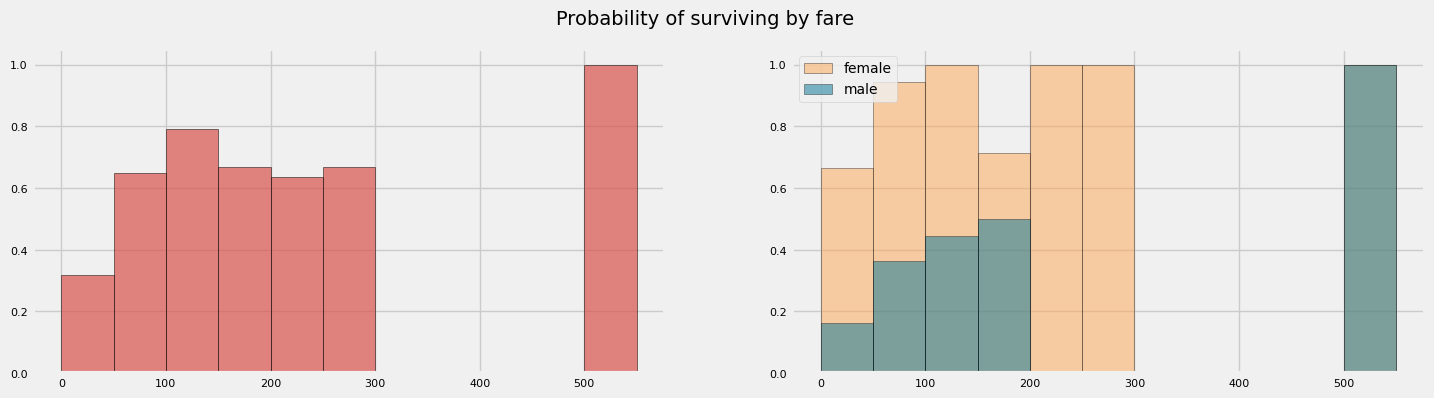

In [110]:
fig = plt.figure(figsize=(16,4))
fig.add_subplot(1,2,1)
plt.bar(edges[:-1], frq00/frq01, width=np.diff(edges), ec="k", align="edge", color=colors[2], alpha=.7)
fig.add_subplot(1,2,2)
plt.bar(edges[:-1], frq3/frq2, width=np.diff(edges), ec="k", align="edge", color=colors[0], alpha=.5, label='female')
plt.bar(edges[:-1], frq1/frq0, width=np.diff(edges), ec="k", align="edge", color=colors[1], alpha=.5, label='male')
plt.legend()
plt.suptitle('Probability of surviving by fare', fontsize=14)
plt.show()

In [17]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Alone'],
      dtype='object')

## Features tweaking

First of all, let us get rid of features which appear clearly unrelated to surviving probability, such as *PassengerId*, *Name*, *Ticket*

In [112]:
df = df.drop(['PassengerId', 'Name', 'Ticket'], axis=1) 

In [113]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin',
       'Embarked', 'Alone'],
      dtype='object')

#### Missing values

In [114]:
df.columns[df.isna().any()].tolist()

['Age', 'Cabin', 'Embarked']

*Age* has a limited number of missing values

In [115]:
print('Number of null values: {0:d}'.format(sum(pd.isnull(df['Age']))))
print('Ratio of null values: {0:5.3f}'.format(sum(pd.isnull(df['Age']))/df.shape[0]))

Number of null values: 177
Ratio of null values: 0.199


We can deal with the problem by inserting a suitable value to fill missing locations. Let us look at the distribution of ages

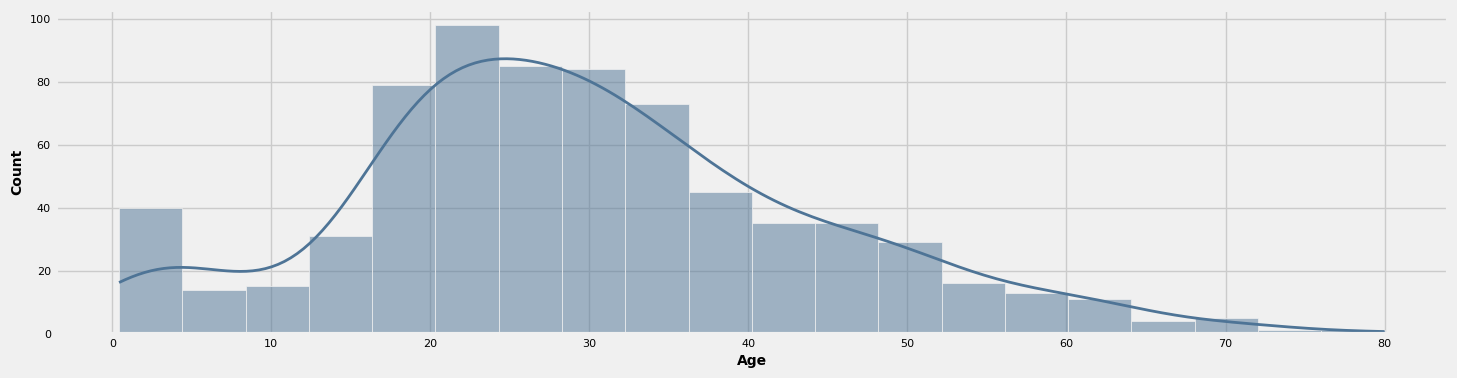

In [118]:
plt.figure(figsize=(16,4))
sns.histplot(df[df['Age'].notnull()]['Age'],kde=True,bins=20, color=colors[8])
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

*Age* is (right) skewed: using the mean might give us biased results by filling in ages that are older than desired. To deal with this, we use the median to impute the missing values.

In [119]:
df['Age'] = df['Age'].fillna(df['Age'].median(skipna=True))

*Cabin* has a larger amount of missing values. 

In [120]:
print('Number of null values: {0:d}'.format(sum(pd.isnull(df['Cabin']))))
print('Ratio of null values: {0:5.3f}'.format(sum(pd.isnull(df['Cabin']))/df.shape[0]))

Number of null values: 687
Ratio of null values: 0.771


Moreover, it do not seem to add much value to the analysis: let us drop it from the dataframe.

In [121]:
df = df.drop(['Cabin'], axis=1) 
df.shape

(891, 9)

*Embarked* has just a few missing values

In [122]:
print('Number of null values: {0:d}'.format(sum(pd.isnull(df['Embarked']))))
print('Ratio of null values: {0:5.3f}'.format(sum(pd.isnull(df['Embarked']))/df.shape[0]))

Number of null values: 2
Ratio of null values: 0.002


Being it a categorical features, we fill missing values with the most frequent class

In [123]:
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].value_counts().argmax())

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
 8   Alone     891 non-null    int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


## One-hot encoding of categorical variables
This apply to *Sex*, *Pclass* and *Embarked*

In [125]:
df = pd.get_dummies(df,drop_first=True,columns=['Sex', 'Embarked', 'Pclass'])

In [126]:
df.head()

,Survived,Age,SibSp,Parch,Fare,Alone,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,0,True,False,False,True,False,True
1,1,38.0,1,0,71.2833,0,False,True,False,False,False,False
2,1,26.0,0,0,7.9250,1,False,False,False,True,False,True
3,1,35.0,1,0,53.1000,0,False,False,False,True,False,False
4,0,35.0,0,0,8.0500,1,True,False,False,True,False,True


## Class balance
Let us check that target classes are balanced

In [127]:
print('Number of positive items: {0:d}'.format(df[df.Survived==1].shape[0]))
print('Number of negative items: {0:d}'.format(df[df.Survived==0].shape[0]))
print('Fraction of positive items: {0:3.2f}'.format(df[df.Survived==1].shape[0]/df.shape[0]))

Number of positive items: 342
Number of negative items: 549
Fraction of positive items: 0.38


There is a certain unbalancement towards negative items. Let us consider it acceptable, for now.

Let us derive the feature matrix and the target vector.

In [128]:
X = df.drop(['Survived'], axis=1)
y = df['Survived']

In [129]:
scaler = StandardScaler()
scaler = scaler.fit(X)
X_s = pd.DataFrame(scaler.transform(X), columns=X.columns)

## Feature selection

In [130]:
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest.fit(X_s, y)
importances = forest.feature_importances_

In [131]:
ff = np.array([e.feature_importances_ for e in forest.estimators_])
dd = pd.DataFrame(ff, columns=X.columns)

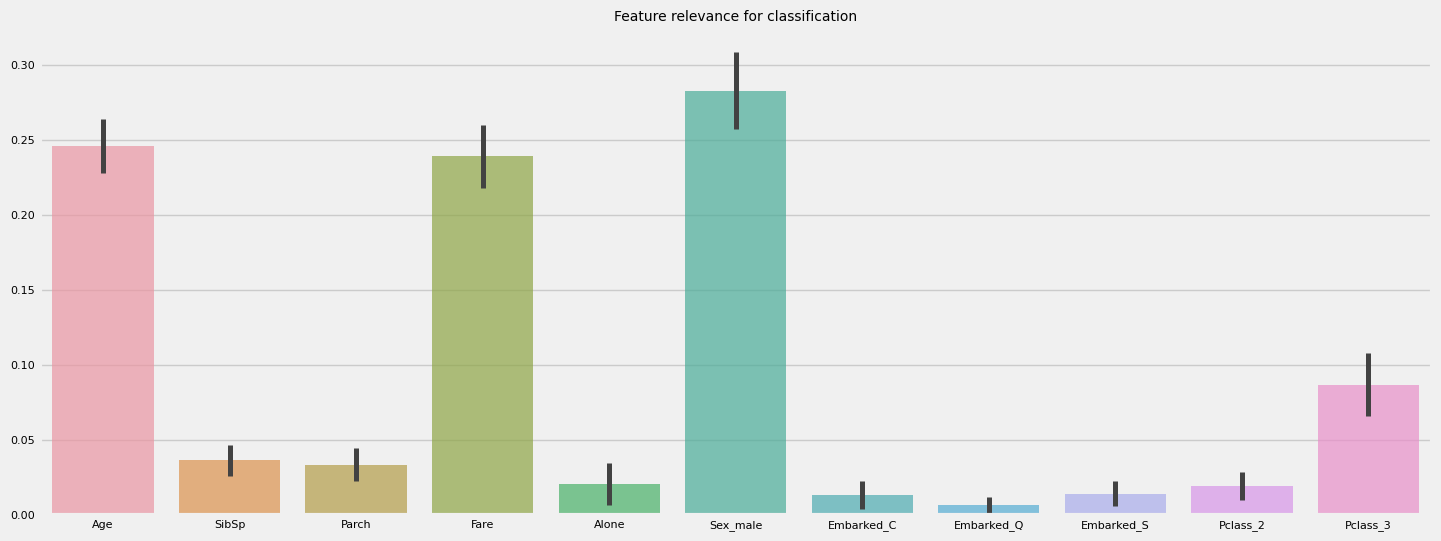

In [135]:
pd.DataFrame.iteritems=pd.DataFrame.items
fig = plt.figure(figsize=(16, 6))
sns.barplot(data=dd, ci="sd", alpha=.7)
plt.title('Feature relevance for classification')
plt.show()

In [136]:
mi = mutual_info_classif(X_s, y)
dmi = pd.DataFrame(mi, index=X.columns, columns=['mi']).sort_values(by='mi', ascending=False)
dmi

,mi
Sex_male,0.163727
Fare,0.138865
Pclass_3,0.040521
SibSp,0.038763
Embarked_S,0.033304
Alone,0.031046
Age,0.020523
Pclass_2,0.009906
Embarked_Q,0.009278
Embarked_C,0.003013


In [38]:
fc = SelectKBest(f_classif, k='all').fit(X_s, y)
dfc = pd.DataFrame(np.array([fc.scores_, fc.pvalues_]).T, index=X.columns, columns=['score','pval']).sort_values(by='score', ascending=False)
dfc

,score,pval
Sex_male,372.405724,1.406066e-69
Pclass_3,103.057599,5.510281e-23
Fare,63.030764,6.120189e-15
Alone,38.353651,9.009490e-10
Embarked_C,25.895987,4.397151e-07
Embarked_S,22.075469,3.036111e-06
Pclass_2,7.814805,5.293655e-03
Parch,5.963464,1.479925e-02
Age,3.761528,5.276069e-02
SibSp,1.110572,2.922439e-01


It seems that 5 features (*Sex_male*, *Pclass_3*, *Fare*, *Alone*, *Age*) are the ones providing most information needed for  prediction. Let us define a reduced matrix containing only values from those features and a function which selects such features from a dataframe

In [39]:
X_sel = X_s[['Sex_male', 'Pclass_3', 'Fare', 'Alone', 'Age']]
cols = [X.columns.get_loc(c) for c in ['Sex_male', 'Pclass_3', 'Fare', 'Alone', 'Age']]

In [40]:
def select_columns(X):
    return np.take(X,cols, axis=1)

We can reduce the dimensionality of the problem also by feature extraction for example by applying PCA

In [41]:
pca = PCA(n_components=X_s.shape[1])
pca = pca.fit(X_s)

In [42]:
evr = pca.explained_variance_ratio_

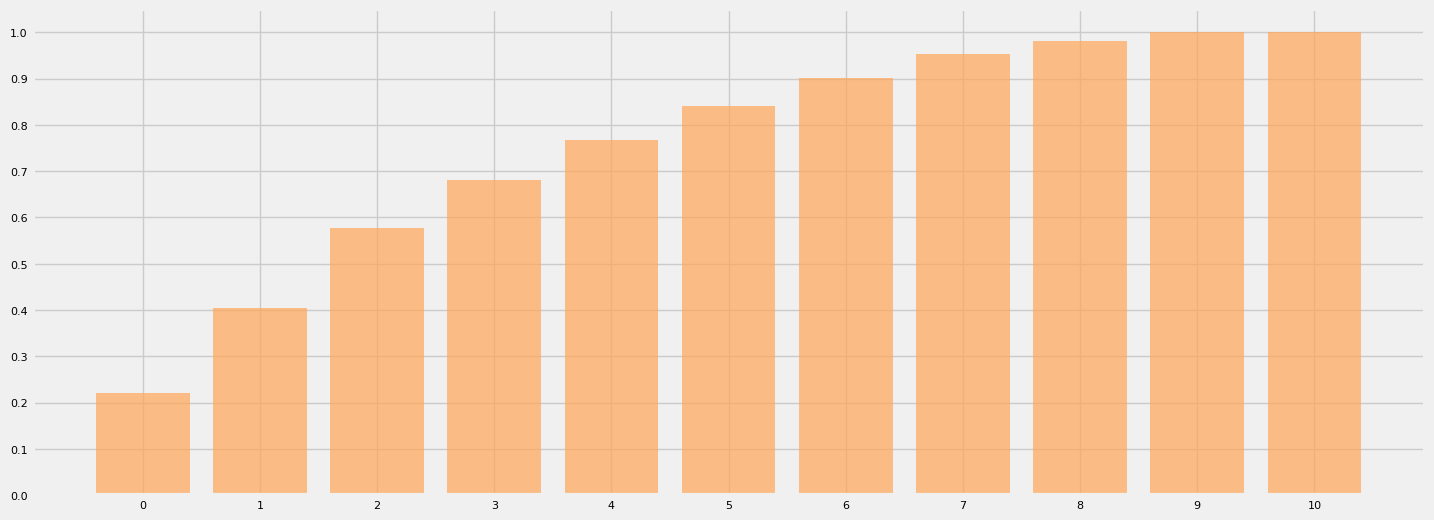

In [43]:
fig = plt.figure(figsize=(16,6))
plt.bar(range(evr.shape[0]), evr.cumsum(), alpha=.7)
plt.xticks(range(evr.shape[0]))
plt.yticks(np.linspace(0,1,11))
plt.show()

In [44]:
X_pca = PCA(n_components=8).fit_transform(X_s)

In [45]:
X_pca.shape

(891, 8)

## Prediction

### Naive Bayes
Classification is performed by creating a classifier and insert it in a pipeline, after a scaler

In [46]:
clf = Pipeline([('scaler', StandardScaler()),('classifier', GaussianNB())])

The classifier is trained by submitting the training set X,y to it. Let us first refer to all features

In [47]:
clf = clf.fit(X,y)

The classifier coefficients are now instantiated according to the submitted training set.  
The classifier can now be applied to prediction. Let us first apply it to the traning set itself (indeed, only to the feature matrix X)

In [48]:
p = clf.predict(X)

## How well did the classifier behave?

We may use several measures here. The ones we consider refer to the following values:

*True positive*: the number of survived passengers (i.e. belonging to class 1) correctly classified  
*True negative*: the number of died passengers (i.e. belonging to class 0) correctly classified  
*False positive*: the number of died passengers (i.e. belonging to class 0) classified as survived  
*False negative*: the number of survived passengers (i.e. belonging to class 1) classified as died

Such values can be reported in a *confusion matrix*. By definition a confusion matrix $C$ is such that $C(i, j)$ is equal to the number of observations known to be in group $i$ but predicted to be in group $j$. That is, rows correspond to classes, columns to predictions.

In [49]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in [['TN', 'FP'],['FN','TP']]]))

TN	FP
FN	TP


In [50]:
cm = confusion_matrix(p, y)

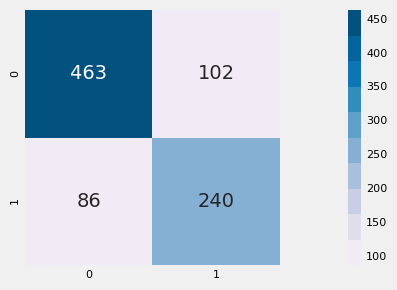

In [51]:
plt.figure(figsize=(14,3))
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 14},
                 cmap = sns.color_palette("PuBu", 10))
plt.tight_layout()
plt.show()

By definition a confusion matrix C is such that C(i, j) is equal to the number of observations known to be in group i but predicted to be in group j. That is, rows correspond to classes, columns to predictions. So, we have here

In [52]:
print('{0:4d} true positives'.format(cm[1,1]))
print('{0:4d} false negatives'.format(cm[1,0]))
print('{0:4d} false positives'.format(cm[0,1]))
print('{0:4d} true negatives'.format(cm[0,0]))

 240 true positives
  86 false negatives
 102 false positives
 463 true negatives


*Precision* is defined as the ratio of elements predicted as positive which are indeed positive: P=TP/(TP+FP). In this case, the ratio of survived passenger correctly classified wrt the total number of passengers classified as survived

*Recall* is defined as the ratio of positive elements which are predicted as positive: P=TP/(TP+FN). In this case, the ratio of survived passenger correctly classified wrt the total number of survived passengers

*F-score* is the harmonic mean of precision and recall $fscore = (precision^{-1}+recall^{-1})^{-1}$

*Accuracy* is defined as the ratio of correctly classified elements wrt to the overal number of elements

In [53]:
print('Precision = {0:5.4f}'.format(precision_score(p,y)))
print('Recall = {0:5.4f}'.format(recall_score(p,y)))
print('F-score = {0:5.4f}'.format(f1_score(p,y)))
print('Accuracy = {0:5.4f}'.format(accuracy_score(p,y)))

Precision = 0.7018
Recall = 0.7362
F-score = 0.7186
Accuracy = 0.7890


We may however be interested in precision, recall and f-score for both classes (survived and perished)

In [54]:
m = precision_recall_fscore_support(p,y)

In [55]:
print('Precision class 0 = {0:5.4f}'.format(m[0][0]))
print('Precision class 1 = {0:5.4f}'.format(m[0][1]))
print('Recall class 0 = {0:5.4f}'.format(m[1][0]))
print('Recall class 1 = {0:5.4f}'.format(m[1][1]))
print('F-score class 0 = {0:5.4f}'.format(m[2][0]))
print('F-score class 1 = {0:5.4f}'.format(m[2][1]))
print('Accuracy = {0:5.4f}'.format(accuracy_score(p,y)))

Precision class 0 = 0.8434
Precision class 1 = 0.7018
Recall class 0 = 0.8195
Recall class 1 = 0.7362
F-score class 0 = 0.8312
F-score class 1 = 0.7186
Accuracy = 0.7890


The model also returns measures of the confidence of passenger predictions, in terms of probabilities. 

*class probabilities*: the estimated probability that a passenger is survived

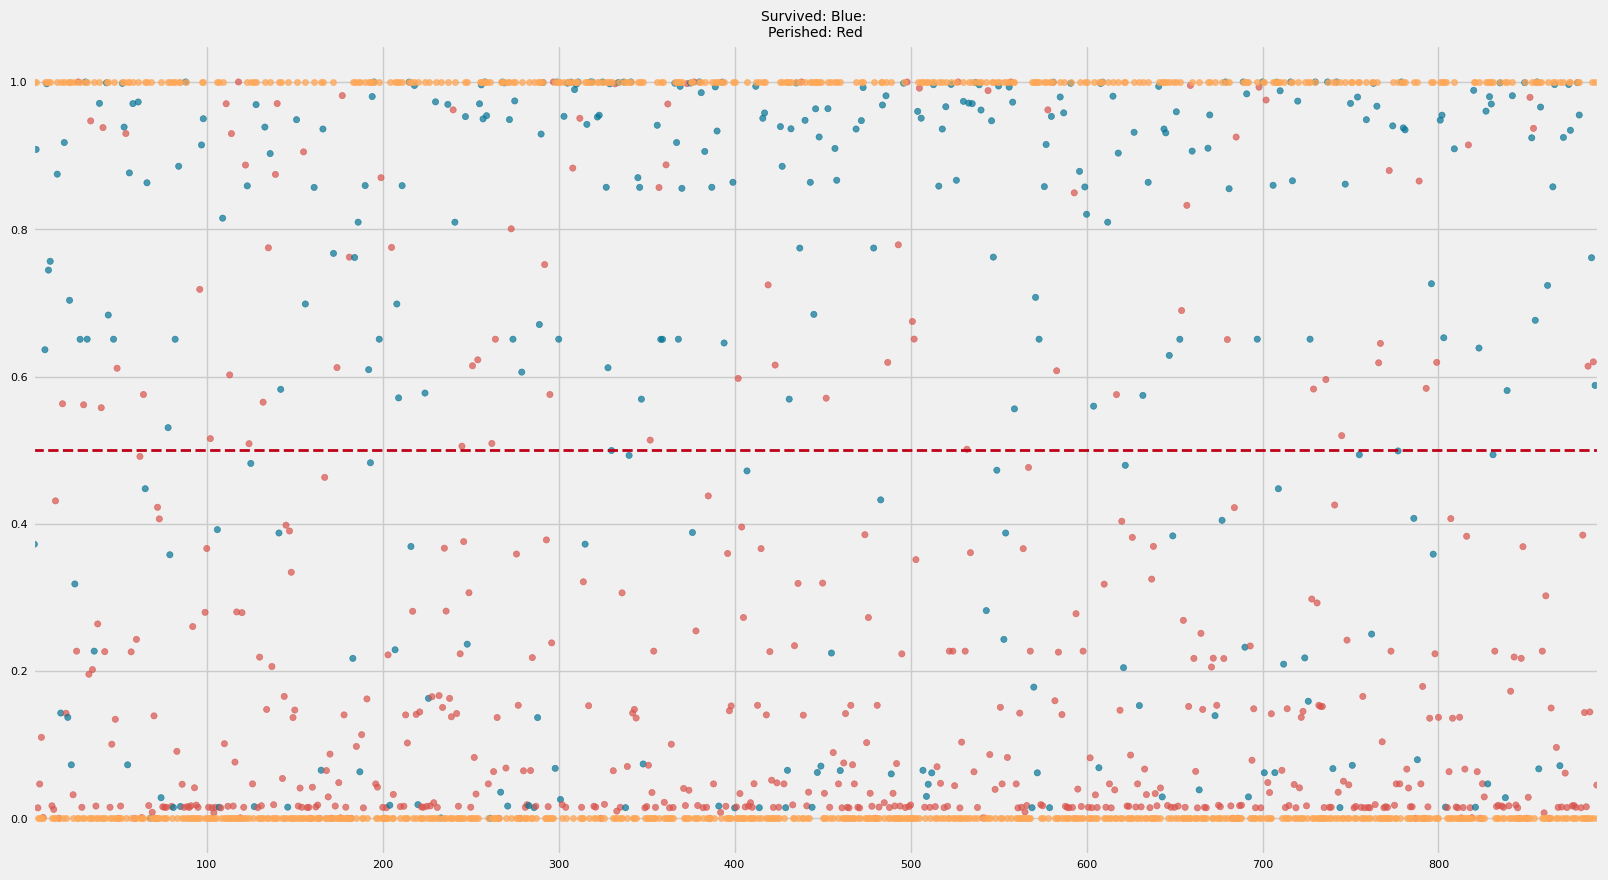

In [56]:
y_prob = clf.predict_proba(X)
c = list(y.apply(lambda x: colors[1] if x==1 else colors[2]))
plt.figure(figsize=(18,10))
plt.scatter(range(y_prob.shape[0]), y_prob[:,1], color=c, s = 20, marker='o', alpha=.7)
plt.plot(range(y_prob.shape[0]), y, color=colors[0], ms = 4, marker='o', linestyle=' ', alpha=.7)
plt.axhline(y=.5, xmin=0, xmax=1, linewidth=2, linestyle='dashed', color=colors[9])
plt.xlim(1,y_prob.shape[0])
plt.title('Survived: Blue: \nPerished: Red');
plt.show()

A ROC (Receiver Operating Characteristic) curve represents, for any value of the threshold applied to the probabilities for classification, the ratio $\frac{FP}{N}=\frac{FP}{TN+FP}$ of negative elements incorrectly classified as positive (*False positive rate*) and the ratio $\frac{TP}{P}=\frac{TP}{TP+FN}$ of positive elements correctly classified as positive (*True positive rate*).

The ideal point is (0,1): no negative elements misclassified, all positive elements well classified.

In [57]:
fpr, tpr, thresholds = roc_curve(y, clf.predict_proba(X)[:,1], pos_label=1)

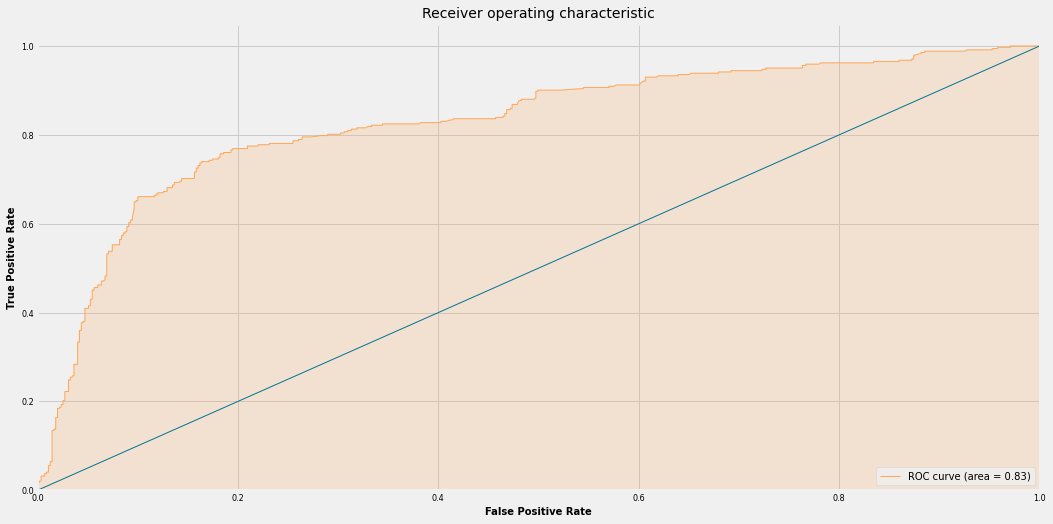

In [63]:
plt.figure(figsize=(16,8))
plt.plot(fpr, tpr, color=colors[0], linewidth=1,label='ROC curve (area = %0.2f)' %  auc(fpr, tpr))
plt.fill_between(fpr, 0, tpr, alpha=0.2)
plt.plot([0, 1], [0, 1], color=colors[1], linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel(r'True Positive Rate')
plt.xlabel(r'False Positive Rate')
plt.title('Receiver operating characteristic', fontsize=14)
plt.legend(loc="lower right")
plt.show()

The Area under curve (AUC) provides a measure of the quality of the classifier. More precisely, it corresponds to the probability that a classifier ranks a random positive item higher than a random negative one (that is assigns it a higher probability of being positive).

In [58]:
print('AUC = {0:0.4f}'.format(auc(fpr, tpr)))

AUC = 0.8283


In [59]:
roc_auc_score(y, clf.predict_proba(X)[:,1])

0.8283188998604587

In [60]:
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]

In [61]:
print('Optimal threshold: {0:3.3f}'.format(optimal_threshold))

Optimal threshold: 0.432


In [62]:
pred_proba_df = pd.DataFrame(clf.predict_proba(X)[:,1])
p = pred_proba_df.applymap(lambda x: 1 if x>optimal_threshold else 0)

In [63]:
cm = confusion_matrix(y,p)

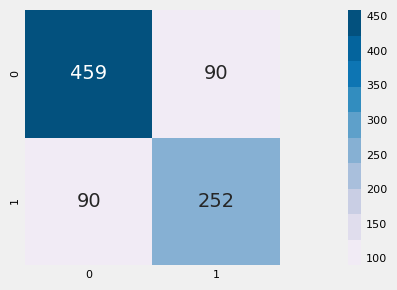

In [64]:
plt.figure(figsize=(14,3))
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 14},
                 cmap = sns.color_palette("PuBu", 10))
plt.tight_layout()
plt.show()

In [71]:
m = precision_recall_fscore_support(p,y)

In [72]:
print('Precision class 0 = {0:5.4f}'.format(m[0][0]))
print('Precision class 1 = {0:5.4f}'.format(m[0][1]))
print('Recall class 0 = {0:5.4f}'.format(m[1][0]))
print('Recall class 1 = {0:5.4f}'.format(m[1][1]))
print('F-score class 0 = {0:5.4f}'.format(m[2][0]))
print('F-score class 1 = {0:5.4f}'.format(m[2][1]))
print('Accuracy = {0:5.4f}'.format(accuracy_score(p,y)))

Precision class 0 = 0.8361
Precision class 1 = 0.7368
Recall class 0 = 0.8361
Recall class 1 = 0.7368
F-score class 0 = 0.8361
F-score class 1 = 0.7368
Accuracy = 0.7980


A better evaluation can be obtained by using a training set - test set pair

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [74]:
clf = Pipeline([('scaler', StandardScaler()),('classifier', GaussianNB())]).fit(X_train, y_train)

Perform predictions on both training and test set

In [75]:
p_train = clf.predict(X_train)
p_test = clf.predict(X_test)

Compute measures in both cases

In [76]:
cm_train = confusion_matrix(y_train,p_train)
cm_test = confusion_matrix(y_test,p_test)

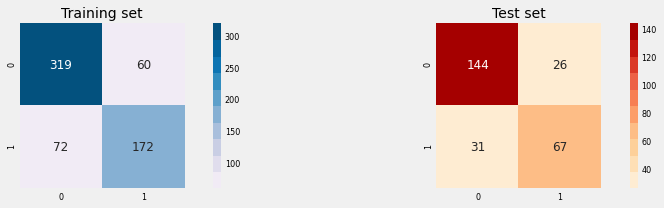

In [77]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
hm = sns.heatmap(cm_train,cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 12},cmap = sns.color_palette("PuBu", 10))
plt.title('Training set', fontsize=14)
plt.subplot(1,2,2)
hm = sns.heatmap(cm_test,cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 12},cmap = sns.color_palette("OrRd", 10))
plt.title('Test set', fontsize=14)
plt.tight_layout()
plt.show()

In [78]:
m_train = precision_recall_fscore_support(y_train,p_train)
m_test = precision_recall_fscore_support(y_test,p_test)

In [79]:
print('TRAINING SET')
print('Precision class 0 = {0:5.4f}'.format(m_train[0][0]))
print('Precision class 1 = {0:5.4f}'.format(m_train[0][1]))
print('Recall class 0 = {0:5.4f}'.format(m_train[1][0]))
print('Recall class 1 = {0:5.4f}'.format(m_train[1][1]))
print('F-score class 0 = {0:5.4f}'.format(m_train[2][0]))
print('F-score class 1 = {0:5.4f}'.format(m_train[2][1]))
print('Accuracy = {0:5.4f}'.format(accuracy_score(p_train,y_train)))

TRAINING SET
Precision class 0 = 0.8159
Precision class 1 = 0.7414
Recall class 0 = 0.8417
Recall class 1 = 0.7049
F-score class 0 = 0.8286
F-score class 1 = 0.7227
Accuracy = 0.7881


In [80]:
print('TEST SET')
print('Precision class 0 = {0:5.4f}'.format(m_test[0][0]))
print('Precision class 1 = {0:5.4f}'.format(m_test[0][1]))
print('Recall class 0 = {0:5.4f}'.format(m_test[1][0]))
print('Recall class 1 = {0:5.4f}'.format(m_test[1][1]))
print('F-score class 0 = {0:5.4f}'.format(m_test[2][0]))
print('F-score class 1 = {0:5.4f}'.format(m_test[2][1]))
print('Accuracy = {0:5.4f}'.format(accuracy_score(p_test,y_test)))

TEST SET
Precision class 0 = 0.8229
Precision class 1 = 0.7204
Recall class 0 = 0.8471
Recall class 1 = 0.6837
F-score class 0 = 0.8348
F-score class 1 = 0.7016
Accuracy = 0.7873


In [81]:
y_prob = clf.predict_proba(X_train)
print('AUC:{0:3.3f}'.format(roc_auc_score(y_train, y_prob[:,1])))

AUC:0.827


A more stable evaluation can be obtained by cross validation (here 7-fold)

In [82]:
scores = cross_validate(estimator=clf, X=X, y=y, cv=7, scoring=('precision', 'recall', 'accuracy', 'f1', 'roc_auc'),
                        return_train_score=True)

In [83]:
print('AUC:{0:3.3f}'.format(scores['test_roc_auc'].mean()))

AUC:0.813


Let us now consider the reduced dataset with selected  features

In [84]:
clf = Pipeline([('scaler', StandardScaler()),('features', FunctionTransformer(select_columns)),
                ('classifier', GaussianNB())])

In [85]:
scores = cross_validate(estimator=clf, X=X, y=y, cv=7, scoring=('precision', 'recall', 'accuracy', 'f1', 'roc_auc'),
                        return_train_score=True)

In [86]:
print('AUC:{0:3.3f}'.format(scores['test_roc_auc'].mean()))

AUC:0.819


And also the one reduced by PCA, with 8 components

In [87]:
clf = Pipeline([('scaler', StandardScaler()),('features', PCA(n_components=8)),
                ('classifier', GaussianNB())])

In [88]:
scores = cross_validate(estimator=clf, X=X, y=y, cv=7, scoring=('precision', 'recall', 'accuracy', 'f1', 'roc_auc'),
                        return_train_score=True)

In [89]:
print('AUC:{0:3.3f}'.format(scores['test_roc_auc'].mean()))

AUC:0.818


In [90]:
clf = clf.fit(X,y)

In [91]:
fpr, tpr, thresholds = roc_curve(y, clf.predict_proba(X)[:,1], pos_label=1)
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
pred_proba_df = pd.DataFrame(clf.predict_proba(X)[:,1])
p = pred_proba_df.applymap(lambda x: 1 if x>optimal_threshold else 0)
print('Optimal threshold: {0:3.3f}'.format(optimal_threshold))

Optimal threshold: 0.371


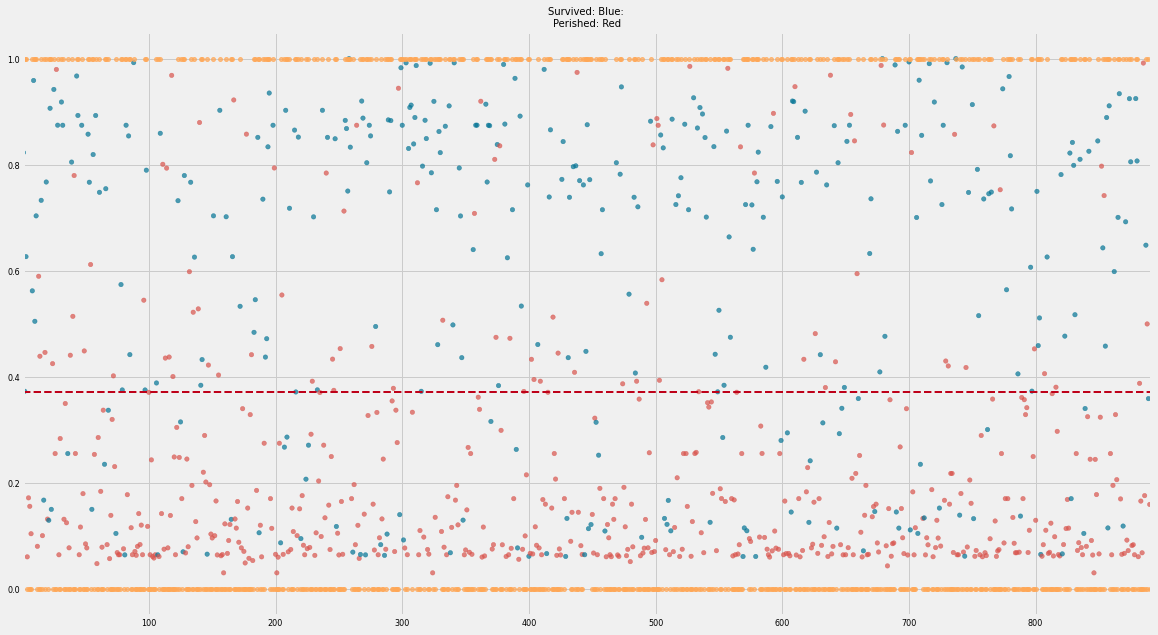

In [92]:
# Plot Predictions Vs Actual
y_prob = clf.predict_proba(X)
c = list(y.apply(lambda x: colors[1] if x==1 else colors[2]))
plt.figure(figsize=(18,10))
plt.scatter(range(y_prob.shape[0]), y_prob[:,1], color=c, s = 20, marker='o', alpha=.7)
plt.plot(range(y_prob.shape[0]), y, color=colors[0], ms = 4, marker='o', linestyle=' ', alpha=.7)
plt.axhline(y=optimal_threshold, xmin=0, xmax=1, linewidth=2, linestyle='dashed', color=colors[9])
plt.xlim(1,y_prob.shape[0])
plt.title('Survived: Blue: \nPerished: Red');
plt.show()

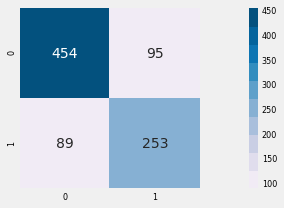

In [93]:
cm = confusion_matrix(y,p)
plt.figure(figsize=(14,3))
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 14},
                 cmap = sns.color_palette("PuBu", 10))
plt.tight_layout()
plt.show()

In [94]:
m = precision_recall_fscore_support(p,y)
print('Precision class 0 = {0:5.4f}'.format(m[0][0]))
print('Precision class 1 = {0:5.4f}'.format(m[0][1]))
print('Recall class 0 = {0:5.4f}'.format(m[1][0]))
print('Recall class 1 = {0:5.4f}'.format(m[1][1]))
print('F-score class 0 = {0:5.4f}'.format(m[2][0]))
print('F-score class 1 = {0:5.4f}'.format(m[2][1]))
print('Accuracy = {0:5.4f}'.format(accuracy_score(p,y)))

Precision class 0 = 0.8270
Precision class 1 = 0.7398
Recall class 0 = 0.8361
Recall class 1 = 0.7270
F-score class 0 = 0.8315
F-score class 1 = 0.7333
Accuracy = 0.7935


### Logistic regression

In [95]:
clf = Pipeline([('scaler', StandardScaler()),('classifier', LogisticRegression())])

In [96]:
scores = cross_validate(estimator=clf, X=X, y=y, cv=7, scoring=('precision', 'recall', 'accuracy', 'f1', 'roc_auc'),
                        return_train_score=True)

In [97]:
print('AUC:{0:3.3f}'.format(scores['test_roc_auc'].mean()))

AUC:0.849


In [98]:
print('Accuracy:{0:3.3f}'.format(scores['test_accuracy'].mean()))

Accuracy:0.800


In [99]:
clf = clf.fit(X,y)

In [100]:
fpr, tpr, thresholds = roc_curve(y, clf.predict_proba(X)[:,1], pos_label=1)
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
pred_proba_df = pd.DataFrame(clf.predict_proba(X)[:,1])
p = pred_proba_df.applymap(lambda x: 1 if x>optimal_threshold else 0)
print('Optimal threshold: {0:3.3f}'.format(optimal_threshold))

Optimal threshold: 0.358


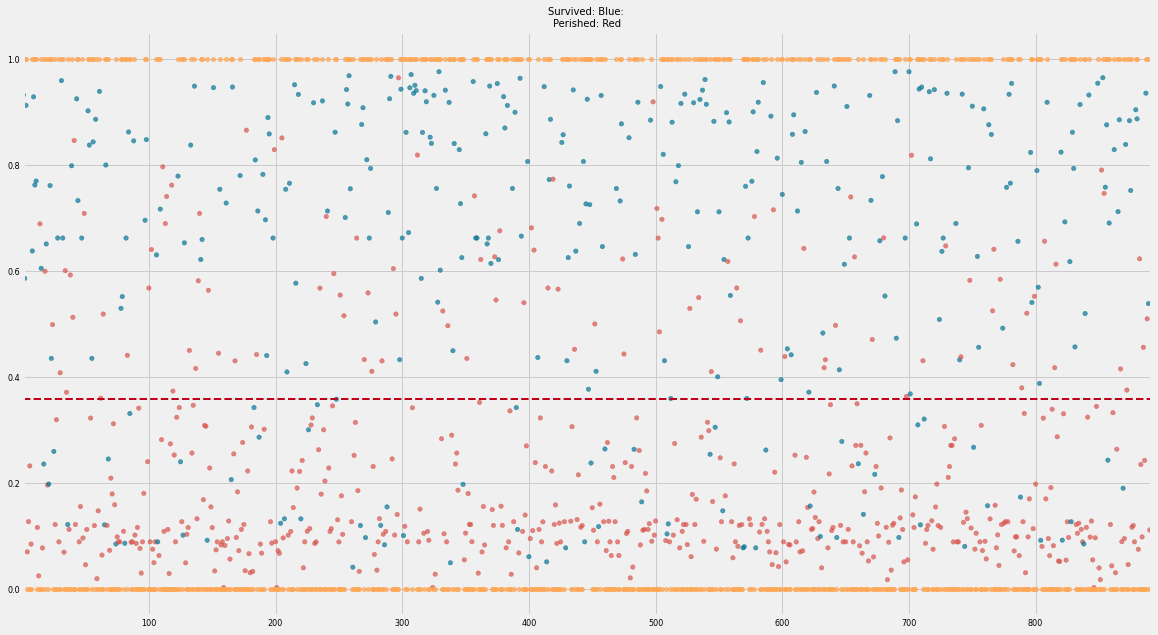

In [101]:
# Plot Predictions Vs Actual
y_prob = clf.predict_proba(X)
c = list(y.apply(lambda x: colors[1] if x==1 else colors[2]))
plt.figure(figsize=(18,10))
plt.scatter(range(y_prob.shape[0]), y_prob[:,1], color=c, s = 20, marker='o', alpha=.7)
plt.plot(range(y_prob.shape[0]), y, color=colors[0], ms = 4, marker='o', linestyle=' ', alpha=.7)
plt.axhline(y=optimal_threshold, xmin=0, xmax=1, linewidth=2, linestyle='dashed', color=colors[9])
plt.xlim(1,y_prob.shape[0])
plt.title('Survived: Blue: \nPerished: Red');
plt.show()

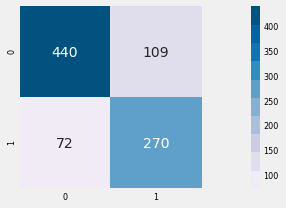

In [102]:
cm = confusion_matrix(y,p)
plt.figure(figsize=(14,3))
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='d',annot_kws={'size': 14},
                 cmap = sns.color_palette("PuBu", 10))
plt.tight_layout()
plt.show()

In [103]:
m = precision_recall_fscore_support(p,y)
print('Precision class 0 = {0:5.4f}'.format(m[0][0]))
print('Precision class 1 = {0:5.4f}'.format(m[0][1]))
print('Recall class 0 = {0:5.4f}'.format(m[1][0]))
print('Recall class 1 = {0:5.4f}'.format(m[1][1]))
print('F-score class 0 = {0:5.4f}'.format(m[2][0]))
print('F-score class 1 = {0:5.4f}'.format(m[2][1]))
print('Accuracy = {0:5.4f}'.format(accuracy_score(p,y)))

Precision class 0 = 0.8015
Precision class 1 = 0.7895
Recall class 0 = 0.8594
Recall class 1 = 0.7124
F-score class 0 = 0.8294
F-score class 1 = 0.7490
Accuracy = 0.7969


### Regularization
Let us introduce a regularization component, with an associated coefficient $C$

In [148]:
domain = np.linspace(0.1,10,100)
param_grid = [{'classifier__C': domain, 'classifier__penalty': ['l1','l2']}]
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
p = Pipeline([('scaler', StandardScaler()),('classifier', LogisticRegression(solver='liblinear'))])

clf = GridSearchCV(p, param_grid, cv=5, scoring=scoring, refit='AUC', return_train_score=True)
clf = clf.fit(X,y)

In [149]:
results = clf.cv_results_

In [150]:
df_results = pd.DataFrame(results)

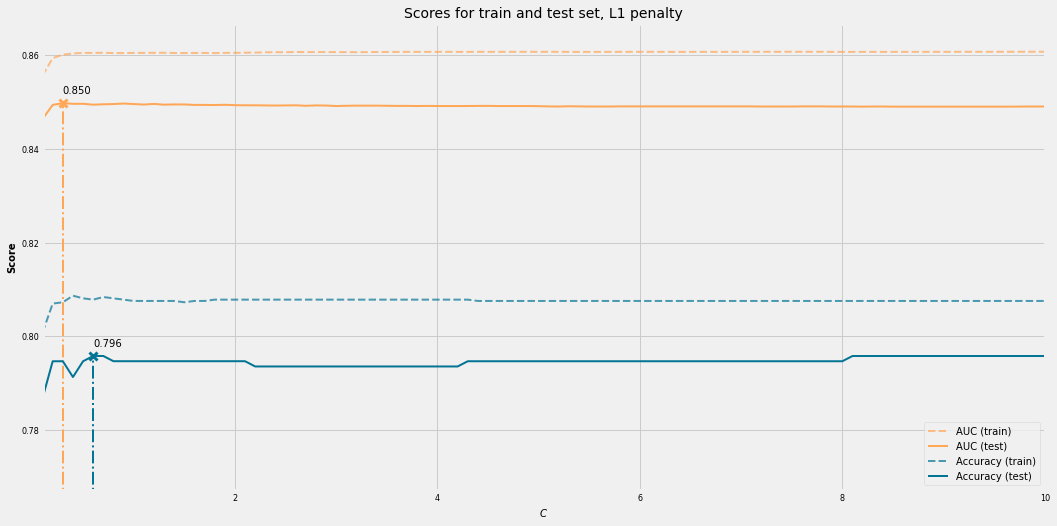

In [151]:
plt.figure(figsize=(16, 8))
dd = df_results[df_results.param_classifier__penalty=='l1']
X_axis = np.array(dd['param_classifier__C'])

mn = 10000
mx = 0
for scorer, color in zip(sorted(scoring), [colors[0], colors[1]]):
    for sample, style in (('train', '--'), ('test', '-')):
        mean = dd['mean_%s_%s' % (sample, scorer)]
        std = dd['std_%s_%s' % (sample, scorer)]
        #plt.fill_between(X_axis, mean-std, mean+std,alpha=0.3 if sample == 'test' else 0, color=color)
        plt.plot(X_axis, mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))
        mn = min(mn, min(mean-std))
        mx = max(mx, max(mean+std))
    scores = np.array(dd['mean_test_%s'% scorer])
    best_index = scores.argmax()
    best_score = scores[best_index]
    plt.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    plt.annotate("%0.3f" % best_score, (X_axis[best_index], best_score + 0.002))

plt.xlabel("$C$")
plt.ylabel("Score")

plt.xlim(0.1, 10)
plt.ylim(mn, mx)
plt.legend()
plt.title("Scores for train and test set, L1 penalty", fontsize=14)
plt.show()

In [154]:
domain = np.linspace(0.01,1,100)
param_grid = [{'classifier__C': domain, 'classifier__penalty': ['l1','l2']}]
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
p = Pipeline([('scaler', StandardScaler()),('classifier', LogisticRegression(solver='liblinear'))])

clf = GridSearchCV(p, param_grid, cv=5, scoring=scoring, refit='AUC', return_train_score=True)
clf = clf.fit(X,y)

In [155]:
results = clf.cv_results_

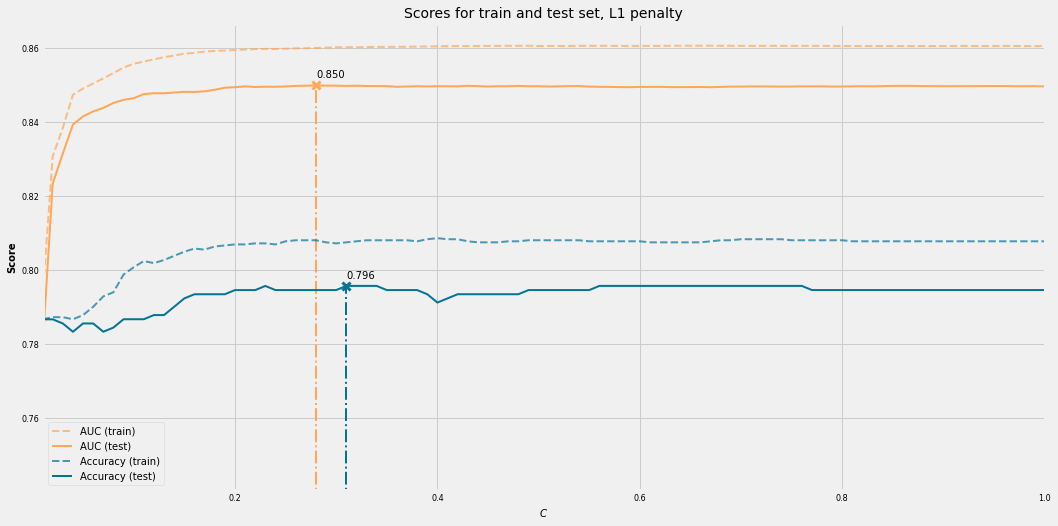

In [156]:
df_results = pd.DataFrame(results)
plt.figure(figsize=(16, 8))
dd = df_results[df_results.param_classifier__penalty=='l1']
X_axis = np.array(dd['param_classifier__C'])

mn = 10000
mx = 0
for scorer, color in zip(sorted(scoring), [colors[0], colors[1]]):
    for sample, style in (('train', '--'), ('test', '-')):
        mean = dd['mean_%s_%s' % (sample, scorer)]
        std = dd['std_%s_%s' % (sample, scorer)]
        plt.plot(X_axis, mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))
        mn = min(mn, min(mean-std))
        mx = max(mx, max(mean+std))
    scores = np.array(dd['mean_test_%s'% scorer])
    best_index = scores.argmax()
    best_score = scores[best_index]
    plt.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    plt.annotate("%0.3f" % best_score, (X_axis[best_index], best_score + 0.002))

plt.xlabel("$C$")
plt.ylabel("Score")

plt.xlim(0.01, 1)
plt.ylim(mn, mx)
plt.legend()
plt.title("Scores for train and test set, L1 penalty", fontsize=14)
plt.show()

In [158]:
domain = np.linspace(0.05,0.25,100)
param_grid = [{'classifier__C': domain, 'classifier__penalty': ['l1','l2']}]
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
p = Pipeline([('scaler', StandardScaler()),('classifier', LogisticRegression(solver='liblinear'))])

clf = GridSearchCV(p, param_grid, cv=5, scoring=scoring, refit='AUC', return_train_score=True)
clf = clf.fit(X,y)

results = clf.cv_results_

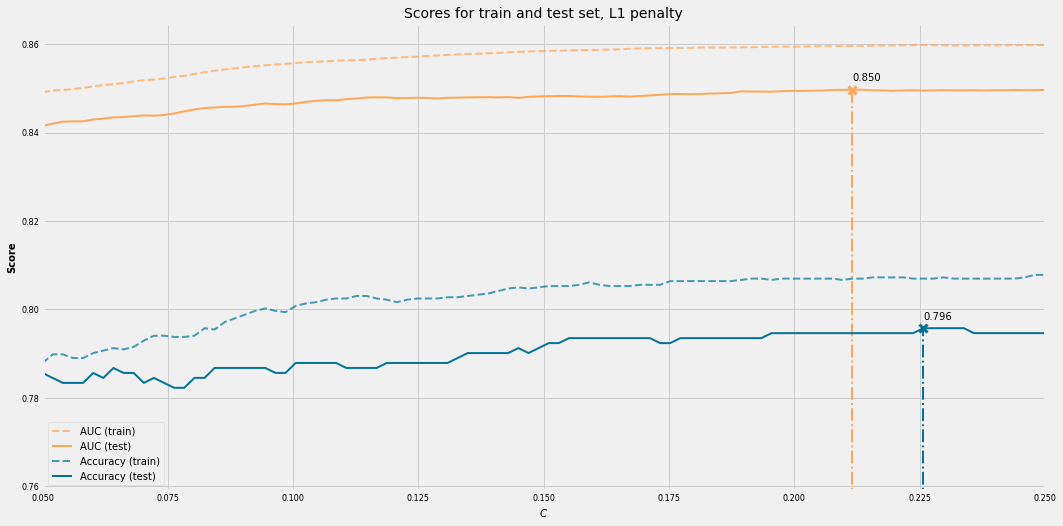

In [159]:
df_results = pd.DataFrame(results)
plt.figure(figsize=(16, 8))
dd = df_results[df_results.param_classifier__penalty=='l1']
X_axis = np.array(dd['param_classifier__C'])

mn = 10000
mx = 0
for scorer, color in zip(sorted(scoring), [colors[0], colors[1]]):
    for sample, style in (('train', '--'), ('test', '-')):
        mean = dd['mean_%s_%s' % (sample, scorer)]
        std = dd['std_%s_%s' % (sample, scorer)]
        plt.plot(X_axis, mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))
        mn = min(mn, min(mean-std))
        mx = max(mx, max(mean+std))
    scores = np.array(dd['mean_test_%s'% scorer])
    best_index = scores.argmax()
    best_score = scores[best_index]
    plt.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    plt.annotate("%0.3f" % best_score, (X_axis[best_index], best_score + 0.002))

plt.xlabel("$C$")
plt.ylabel("Score")

plt.xlim(0.05, 0.25)
plt.ylim(mn, mx)
plt.legend()
plt.title("Scores for train and test set, L1 penalty", fontsize=14)
plt.show()